In [3]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
import sys
import os
import pickle
import time


## Experiment hyperparameters

In [10]:
is_local = True # todo

# Experiment
seed = 5 if is_local else int(sys.argv[-2])
torch.manual_seed(seed)
image_size = 256

# Data: which wavenumbers are even allowed to be considered?
wv_start = 0
wv_end = 965

# Data loading
test_set_fraction = 0.2
val_set_fraction = 0.2
batch_size= 1 # todo 96
patch_dim = 101
use_augmentation = True

# Network
dropout_p=0.5

# Training schedule
lr = 1e-5
l2 = 5e-1
max_iters = 5000
pseudo_epoch = 100

# dimensionality reduction parameters
r_method = 'fixed' # {'linear','pca,'fixed'} # todo change to linear
reduce_dim = 64 if is_local else int(sys.argv[-1]) # used only for r_method = 'pca' or 'linear'
channels_used = np.s_[...,wv_start:wv_end] # used only when r_method = 'fixed'
print(channels_used)

(Ellipsis, slice(0, 965, None))


In [11]:
def csf_fp(filepath):
    return filepath.replace('D:/datasets','D:/datasets' if is_local else './')

master = pd.read_excel(csf_fp(rf'D:/datasets/pcuk2023_ftir_whole_core/master_sheet.xlsx'))
slide = master['slide'].to_numpy()
patient_id = master['patient_id'].to_numpy()
hdf5_filepaths = np.array([csf_fp(fp) for fp in master['hdf5_filepath']])
annotation_filepaths = np.array([csf_fp(fp) for fp in master['annotation_filepath']])
mask_filepaths = np.array([csf_fp(fp) for fp in master['mask_filepath']])
wavenumbers = np.load(csf_fp(f'D:/datasets/pcuk2023_ftir_whole_core/wavenumbers.npy'))[wv_start:wv_end]
wavenumbers_used = wavenumbers[channels_used]

annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)
print(f"Loaded {len(slide)} cores")
print(f"Using {len(wavenumbers_used)}/{len(wavenumbers)} wavenumbers")

Loaded 228 cores
Using 965/965 wavenumbers


## Define datasets and loaders

In [12]:
unique_pids = np.unique(patient_id)
pids_trainval, pids_test, _, _ = train_test_split(
    unique_pids, np.zeros_like(unique_pids), test_size=test_set_fraction, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(
    pids_trainval, np.zeros_like(pids_trainval), test_size=(val_set_fraction/(1-test_set_fraction)), random_state=seed)
where_train = np.where(np.isin(patient_id,pids_train))
where_val = np.where(np.isin(patient_id,pids_val))
where_test = np.where(np.isin(patient_id,pids_test))
print(f"Patients per data split:\n\tTRAIN: {len(where_train[0])}\n\tVAL: {len(where_val[0])}\n\tTEST: {len(where_test[0])}")

Patients per data split:
	TRAIN: 146
	VAL: 44
	TEST: 38


In [13]:
class ftir_annot_dataset(torch.utils.data.Dataset):
    def __init__(self, 
                 hdf5_filepaths, mask_filepaths, annotation_filepaths, channels_use):
        self.hdf5_filepaths = hdf5_filepaths
        self.mask_filepaths = mask_filepaths
        self.annotation_filepaths = annotation_filepaths
        self.channels_use = channels_use
        
        # class data
        self.annotation_class_colors = annotation_class_colors
        self.annotation_class_names = annotation_class_names
        
    def __len__(self):
        return len(self.hdf5_filepaths)
    
    # split annotations from H x W x 3 to C x H x W, one/zerohot along C dimension
    def split_annotations(self,annotations_img):
        split = torch.zeros((len(self.annotation_class_colors),*annotations_img.shape[:-1]))
        for c,col in enumerate(self.annotation_class_colors):
            split[c,:,:] = torch.from_numpy(np.all(annotations_img == self.annotation_class_colors[c],axis=-1)) 
        return split
        
    def __getitem__(self, idx):    
        
        # open hdf5 file
        hdf5_file = h5py.File(self.hdf5_filepaths[idx],'r')
        
        # get mask
        mask = torch.from_numpy(
            hdf5_file['mask'][:],
        ).unsqueeze(0)
        
        # get ftir
        ftir = torch.from_numpy(
            hdf5_file['spectra'][*self.channels_use],
        ).permute(2,0,1)
        hdf5_file.close()
        ftir *= mask
        
        # get annotations
        annotations = self.split_annotations(cv2.imread(self.annotation_filepaths[idx])[:,:,::-1])
        annotations *= mask
        
        
        return ftir, annotations, mask

In [14]:
dataset_train = ftir_annot_dataset(
    hdf5_filepaths[where_train], mask_filepaths[where_train], annotation_filepaths[where_train], channels_used,
)
dataset_val = ftir_annot_dataset(
    hdf5_filepaths[where_val], mask_filepaths[where_val], annotation_filepaths[where_val], channels_used,
)
dataset_test = ftir_annot_dataset(
    hdf5_filepaths[where_test], mask_filepaths[where_test], annotation_filepaths[where_test], channels_used,
)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=False)

## Define model, load weights

In [38]:

with open(r'C:/Users/w37262do/Documents/git/texture_cnn/models/mod2/svm_model_5.pt', 'rb') as f: # todo
    svm_model = pickle.load(f)
with open(r'C:/Users/w37262do/Documents/git/texture_cnn/models/mod2/rf_model_5.pt', 'rb') as f: # todo
    rf_model = pickle.load(f)
    
model = svm_model # todo

C:\Users\w37262do\AppData\Local\anaconda3\envs\phd-env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\w37262do\AppData\Local\anaconda3\envs\phd-env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Nystroem from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\w37262do\AppData\Local\anaconda3\envs\phd-env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Lin

## Loop through datasets

#### Train

In [29]:
time_total = 0

In [30]:
set_preds,set_targets = [], []
pred_images, annot_images = [], []
loader_use = train_loader
start_t = time.time()
with torch.no_grad():
    for bidx, (data, annot, mask) in enumerate(loader_use):
        print(f"{bidx}/{len(loader_use)}",end='\r')
        has_annot = annot.sum(dim=1) != 0
        
        out = model.predict(data.squeeze().flatten(1).permute(1,0).numpy())
        out = out.reshape(1,256,256)
        
        targets = annot.argmax(dim=1)[has_annot]
        preds = out[has_annot]
        set_targets.extend(targets.detach().cpu().numpy())
        set_preds.extend(preds)
        
        bg = data[:,229,:,:].clone()
        for b in range(bg.shape[0]): bg[b] -= bg[b].min()
        for b in range(bg.shape[0]): bg[b] /= bg[b].max()
        bg = torch.stack([bg,bg,bg],dim=-1).detach().cpu().numpy()
        
        # Prediction images
        pred_image = annotation_class_colors[out] / 255.0
        pred_image *= mask.squeeze().unsqueeze(-1).cpu().numpy()
        pred_images.extend(pred_image)
        annot_image = annotation_class_colors[annot.argmax(1).detach().cpu().numpy()] / 255.0
        annot_image *= has_annot.squeeze().unsqueeze(-1).cpu().numpy()
        annot_image = np.where(has_annot.unsqueeze(-1).repeat(1,1,1,1,3).detach().cpu().numpy(), annot_image, bg)[0]
        annot_images.extend(annot_image)
time_total += time.time() - start_t 

# calculate test set metrics
set_acc = accuracy_score(set_targets, set_preds)
set_f1m = f1_score(set_targets, set_preds, average='macro')
set_f1 = f1_score(set_targets, set_preds, average=None)

print(f"DATASET TRAIN --- | OA: {set_acc:.4} | f1: {set_f1m:.4}")
for cls_idx, f1 in enumerate(set_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4}")

AttributeError: 'DecisionTreeClassifier' object has no attribute 'monotonic_cst'

In [ ]:
if is_local:
    i = 0
    for i in range(0,len(pred_images),2):
        fig,ax = plt.subplots(1,2,figsize=(16.5,16.5/4)); ax = ax.flatten()
        ax[0].matshow(np.hstack([pred_images[i],annot_images[i]])); ax[0].set_axis_off()
        ax[1].matshow(np.hstack([pred_images[i+1],annot_images[i+1]])); ax[1].set_axis_off()
        fig.tight_layout()

#### Val

In [ ]:
set_preds,set_targets = [], []
pred_images, annot_images = [], []
loader_use = val_loader
start_t = time.time()
with torch.no_grad():
    for bidx, (data, annot, mask) in enumerate(loader_use):
        print(f"{bidx}/{len(loader_use)}",end='\r')
        has_annot = annot.sum(dim=1) != 0
        
        out = model.predict(data.squeeze().flatten(1).permute(1,0).numpy())
        out = out.reshape(1,256,256)
        
        targets = annot.argmax(dim=1)[has_annot]
        preds = out[has_annot]
        set_targets.extend(targets.detach().cpu().numpy())
        set_preds.extend(preds)
        
        bg = data[:,229,:,:].clone()
        for b in range(bg.shape[0]): bg[b] -= bg[b].min()
        for b in range(bg.shape[0]): bg[b] /= bg[b].max()
        bg = torch.stack([bg,bg,bg],dim=-1).detach().cpu().numpy()
        
        # Prediction images
        pred_image = annotation_class_colors[out] / 255.0
        pred_image *= mask.squeeze().unsqueeze(-1).cpu().numpy()
        pred_images.extend(pred_image)
        annot_image = annotation_class_colors[annot.argmax(1).detach().cpu().numpy()] / 255.0
        annot_image *= has_annot.squeeze().unsqueeze(-1).cpu().numpy()
        annot_image = np.where(has_annot.unsqueeze(-1).repeat(1,1,1,1,3).detach().cpu().numpy(), annot_image, bg)[0]
        annot_images.extend(annot_image)
time_total += time.time() - start_t 
        
# calculate test set metrics
set_acc = accuracy_score(set_targets, set_preds)
set_f1m = f1_score(set_targets, set_preds, average='macro')
set_f1 = f1_score(set_targets, set_preds, average=None)

print(f"DATASET VAL ----- | OA: {set_acc:.4} | f1: {set_f1m:.4}")
for cls_idx, f1 in enumerate(set_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4}")

In [ ]:
if is_local:
    i = 0
    for i in range(0,len(pred_images),2):
        fig,ax = plt.subplots(1,2,figsize=(16.5,16.5/4)); ax = ax.flatten()
        ax[0].matshow(np.hstack([pred_images[i],annot_images[i]])); ax[0].set_axis_off()
        ax[1].matshow(np.hstack([pred_images[i+1],annot_images[i+1]])); ax[1].set_axis_off()
        fig.tight_layout()

#### Test

In [26]:
set_preds,set_targets = [], []
pred_images, annot_images = [], []
loader_use = test_loader
start_t = time.time()
with torch.no_grad():
    for bidx, (data, annot, mask) in enumerate(loader_use):
        print(f"{bidx}/{len(loader_use)}",end='\r')
        has_annot = annot.sum(dim=1) != 0
        
        out = model.predict(data.squeeze().flatten(1).permute(1,0).numpy())
        out = out.reshape(1,256,256)
        
        targets = annot.argmax(dim=1)[has_annot]
        preds = out[has_annot]
        set_targets.extend(targets.detach().cpu().numpy())
        set_preds.extend(preds)
        
        bg = data[:,229,:,:].clone()
        for b in range(bg.shape[0]): bg[b] -= bg[b].min()
        for b in range(bg.shape[0]): bg[b] /= bg[b].max()
        bg = torch.stack([bg,bg,bg],dim=-1).detach().cpu().numpy()
        
        # Prediction images
        pred_image = annotation_class_colors[out] / 255.0
        pred_image *= mask.squeeze().unsqueeze(-1).cpu().numpy()
        pred_images.extend(pred_image)
        annot_image = annotation_class_colors[annot.argmax(1).detach().cpu().numpy()] / 255.0
        annot_image *= has_annot.squeeze().unsqueeze(-1).cpu().numpy()
        annot_image = np.where(has_annot.unsqueeze(-1).repeat(1,1,1,1,3).detach().cpu().numpy(), annot_image, bg)[0]
        annot_images.extend(annot_image)
time_total += time.time() - start_t 
        
# calculate test set metrics
set_acc = accuracy_score(set_targets, set_preds)
set_f1m = f1_score(set_targets, set_preds, average='macro')
set_f1 = f1_score(set_targets, set_preds, average=None)

print(f"DATASET TEST ---- | OA: {set_acc:.4} | f1: {set_f1m:.4}")
for cls_idx, f1 in enumerate(set_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4}")

KeyboardInterrupt: 

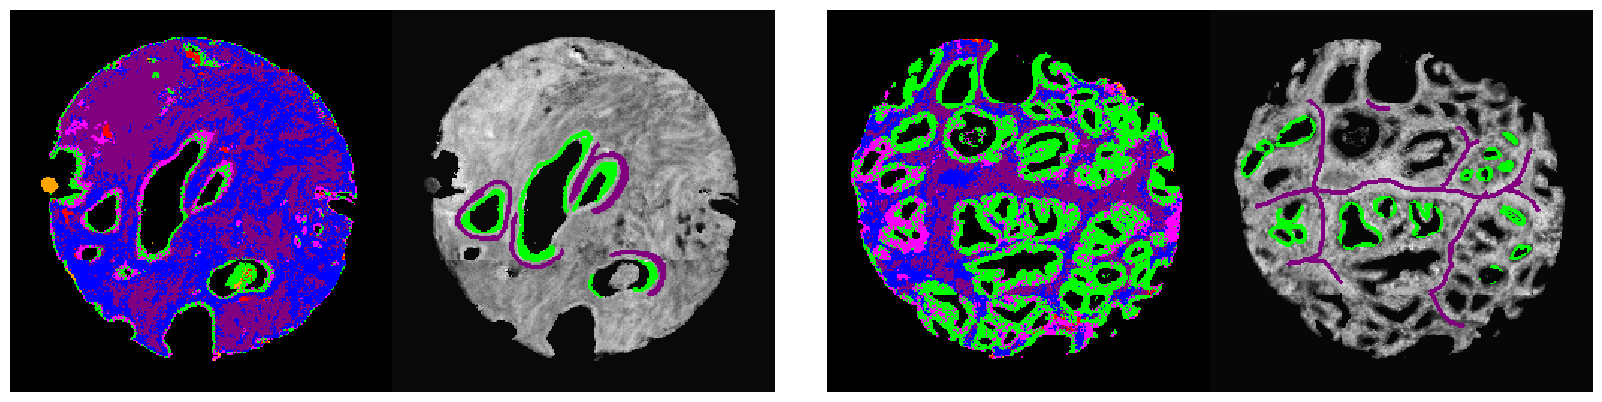

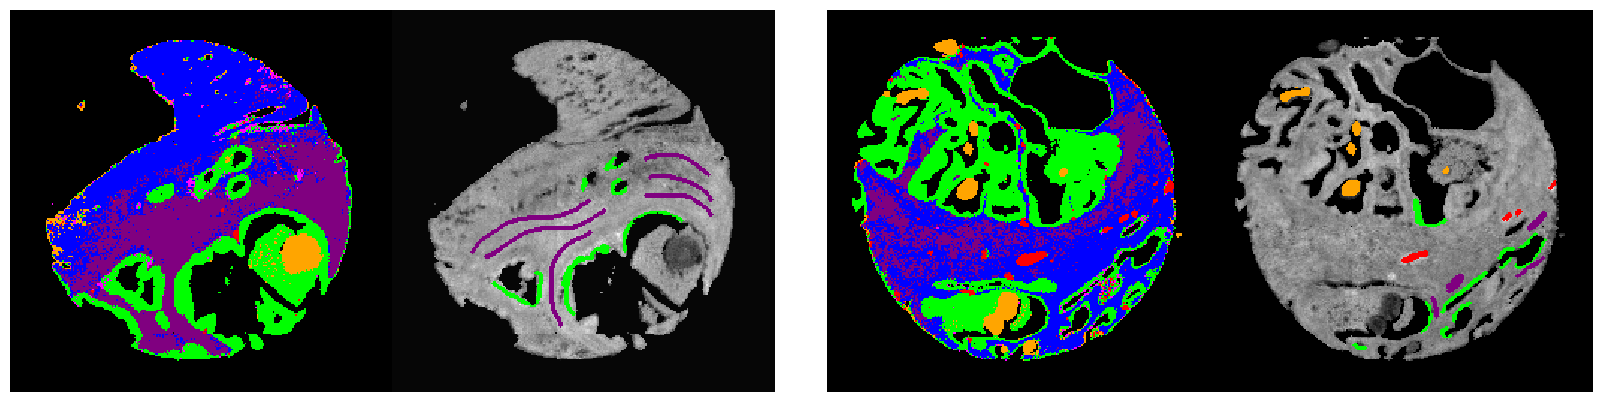

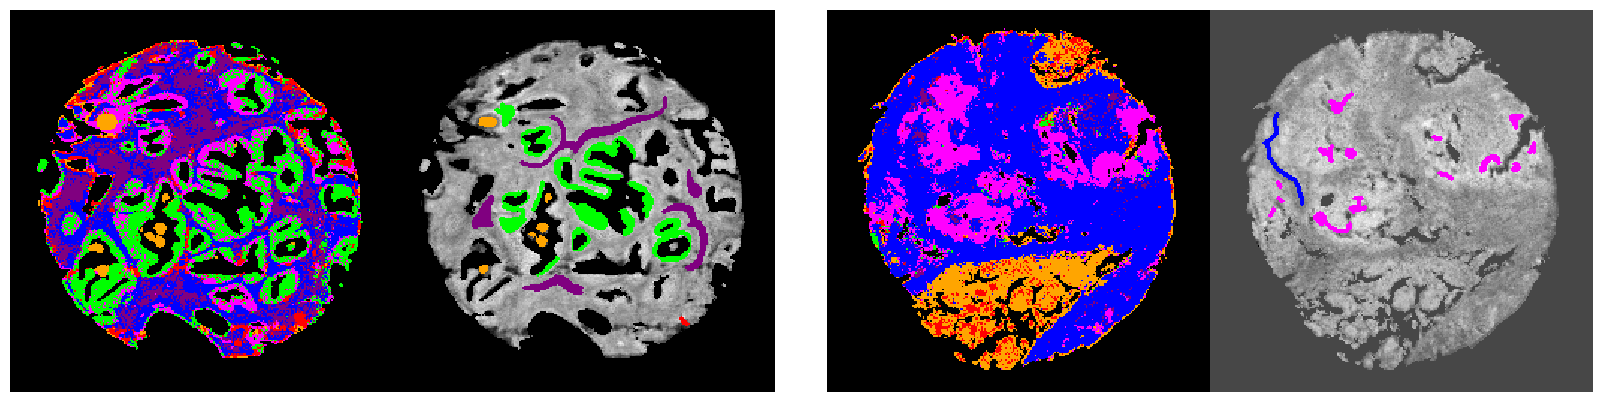

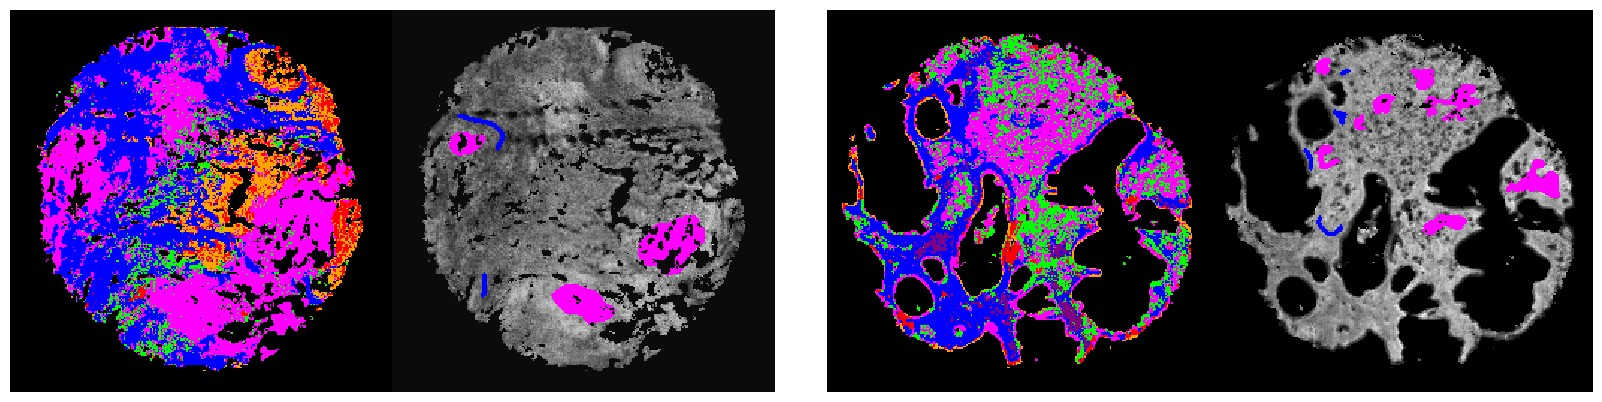

In [27]:
if is_local:
    i = 0
    for i in range(0,len(pred_images),2):
        fig,ax = plt.subplots(1,2,figsize=(16.5,16.5/4)); ax = ax.flatten()
        ax[0].matshow(np.hstack([pred_images[i],annot_images[i]])); ax[0].set_axis_off()
        ax[1].matshow(np.hstack([pred_images[i+1],annot_images[i+1]])); ax[1].set_axis_off()
        fig.tight_layout()

In [ ]:
print(f"TIME TOTAL FOR ALL IMAGES: {time_total}")